# 📂 Load and Explore Dataset
We will load:
- **Metadata file**: Contains information about images.
- **Ground truth labels**: Multi-class classification labels.
- **Image files**: Actual skin lesion images.


In [12]:
import os
import torch
import torchvision.transforms as transforms
import torchvision.models as models
#import timm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
from sklearn.utils import resample


Metadata Sample:


,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male



Ground Truth Sample:


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


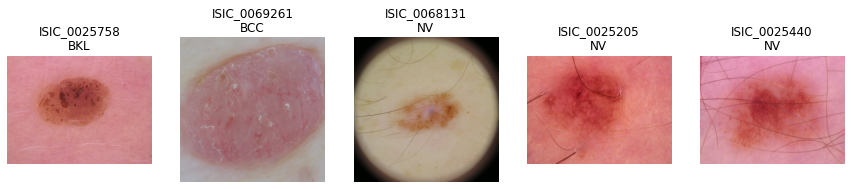

In [13]:
metadata_path = "/kaggle/input/isic-2019/ISIC_2019_Training_Metadata.csv"
groundtruth_path = "/kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv"
image_dir = "/kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input"
metadata_df = pd.read_csv(metadata_path)
groundtruth_df = pd.read_csv(groundtruth_path)

print("Metadata Sample:")
display(metadata_df.head())

print("\nGround Truth Sample:")
display(groundtruth_df.head())

def display_sample_images(image_list, image_dir, groundtruth_df, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i, img_name in enumerate(image_list[:num_images]):
        img_path = os.path.join(image_dir, img_name + ".jpg")

        if not os.path.exists(img_path):
            print(f"Warning: Image {img_name}.jpg not found!")
            axes[i].set_title("Image Not Found")
            axes[i].axis("off")
            continue

        img = cv2.imread(img_path)

        if img is None:
            print(f"Error: Failed to load {img_name}.jpg")
            axes[i].set_title("Load Error")
            axes[i].axis("off")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        row = groundtruth_df[groundtruth_df['image'] == img_name].iloc[:, 1:]
        cancer_type = row.columns[row.values.argmax()]

        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"{img_name}\n{cancer_type}")

    plt.show()

sample_images = groundtruth_df.sample(5)['image'].values
display_sample_images(sample_images, image_dir, groundtruth_df)


# 📊 Class Distribution
We will visualize the class distribution to understand the imbalance in the dataset.

The graph shows the class distribution of images in the ISIC 2019 dataset, which is used for skin cancer classification. The x-axis represents different types of skin cancer or lesions, while the y-axis shows the number of images corresponding to each category.

Here's a breakdown of the categories and the number of images for each:

- NV (Nevus): This category has the highest number of images, with over 12,000 images, represented by the tallest bar.
- MEL (Melanoma): The second-largest group with around 4,000 images.
- BCC (Basal Cell Carcinoma): This category contains around 3,000 images.
- BKL (Benign Keratosis-like lesions): This category has fewer images, just above 2,000.
- AK (Actinic Keratosis): This is a smaller category, with fewer than 1,000 images.
- DF (Dermatofibroma): This category also has fewer images.
- VASC (Vascular lesions): Represented by a smaller bar, indicating fewer images.
- SCC (Squamous Cell Carcinoma): This is another small group with very few images.
- UNK (Unknown): This category represents unknown or uncategorized images and is also small in terms of the number of images.
  
In summary, the dataset is heavily imbalanced, with the "NV" category having significantly more images compared to the other categories. This imbalance might need to be addressed when training machine learning models for skin cancer classification.


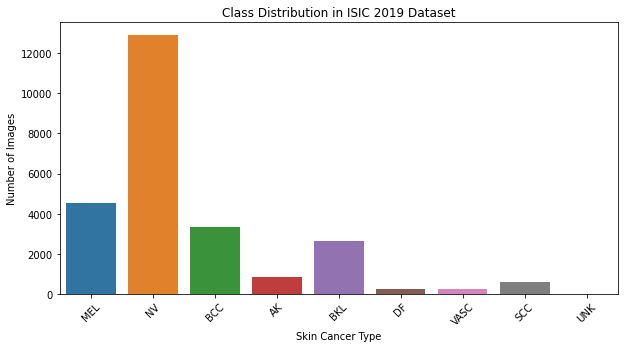

In [14]:
class_counts = groundtruth_df.iloc[:, 1:].sum()
plt.figure(figsize=(10, 5))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xticks(rotation=45)
plt.xlabel("Skin Cancer Type")
plt.ylabel("Number of Images")
plt.title("Class Distribution in ISIC 2019 Dataset")
plt.show()


In [15]:
import os, json
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import StratifiedKFold

# --------------------------
# Paths
# --------------------------
image_dir = "/kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input"
gt_csv    = "/kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv"

# --------------------------
# Labels
# --------------------------
df_labels = pd.read_csv(gt_csv)

# All columns except "image" are classes
label_cols = [c for c in df_labels.columns if c.lower() != "image"]
y = df_labels[label_cols].values
y_idx = y.argmax(axis=1)
df_labels["label_idx"] = y_idx

num_classes = len(label_cols)
print("Classes:", label_cols)
print("Total samples:", len(df_labels))

# Save class order for later fusion/inference
with open("image_labels.json", "w") as f:
    json.dump({"label_cols": label_cols}, f, indent=2)

# --------------------------
# Train/Val split
# --------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, val_idx = next(skf.split(df_labels["image"].values, df_labels["label_idx"].values))
train_df = df_labels.iloc[train_idx].reset_index(drop=True)
val_df   = df_labels.iloc[val_idx].reset_index(drop=True)

# Save split indices (optional, for reproducibility)
np.save("train_idx.npy", train_idx)
np.save("val_idx.npy", val_idx)

# --------------------------
# Dataset
# --------------------------
class ISICImageDataset(Dataset):
    def __init__(self, df, image_dir, tfm):
        self.df = df
        self.image_dir = image_dir
        self.tfm = tfm
        self.ids = df["image"].tolist()
        self.labels = df["label_idx"].astype(int).tolist()

    def __len__(self): return len(self.df)

    def __getitem__(self, i):
        img_id = self.ids[i]
        label  = self.labels[i]
        img_path = os.path.join(self.image_dir, f"{img_id}.jpg")
        if not os.path.isfile(img_path):
            img_path = os.path.join(self.image_dir, f"{img_id}.png")  # fallback
        img = Image.open(img_path).convert("RGB")
        x = self.tfm(img)
        return {"id": img_id, "image": x, "label": label}

# --------------------------
# Transforms
# --------------------------
IMG_SIZE = 224
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])
val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

# --------------------------
# Dataloaders
# --------------------------
BATCH_SIZE = 32
train_ds = ISICImageDataset(train_df, image_dir, train_tfms)
val_ds   = ISICImageDataset(val_df,   image_dir, val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# --------------------------
# ResNet50 Model
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = models.resnet50(pretrained=True)   # if this errors (no internet), switch to pretrained=False
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)
resnet = resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)

# --------------------------
# Training loop
# --------------------------
EPOCHS = 5
for epoch in range(EPOCHS):
    resnet.train()
    total_loss = 0.0
    for batch in train_loader:
        x, yb = batch["image"].to(device), batch["label"].to(device)
        optimizer.zero_grad()
        logits = resnet(x)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {total_loss/len(train_loader):.4f}")

# --------------------------
# Save trained model
# --------------------------
torch.save(resnet.state_dict(), "resnet50_image_expert.pt")
print("Saved model: resnet50_image_expert.pt")

# --------------------------
# Collect validation probabilities
# --------------------------
def get_probs(model, loader):
    model.eval()
    all_ids, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for batch in loader:
            x = batch["image"].to(device)
            yb = batch["label"].cpu().numpy()
            ids = batch["id"]
            logits = model(x)
            probs = F.softmax(logits, dim=1).cpu().numpy()
            all_ids.extend(ids)
            all_probs.append(probs)
            all_labels.extend(yb)
    return np.array(all_ids, dtype="U64"), np.vstack(all_probs), np.array(all_labels, dtype=np.int64)

val_ids_img, P_val_img, y_val = get_probs(resnet, val_loader)
print("Validation probs shape:", P_val_img.shape)

# --------------------------
# Save FINAL validation artifacts (fixed y_val var name; safe ID dtype)
# --------------------------
np.save("oof_img_probs.npy",  P_val_img)                 # [N_val, num_classes]
np.save("oof_img_labels.npy", y_val)                     # [N_val]
np.save("oof_img_ids.npy",    val_ids_img.astype("U64")) # [N_val], safe string dtype (no pickle)

# Also save the exact class order used
with open("image_artifacts.json", "w") as f:
    json.dump({"label_cols": label_cols}, f, indent=2)

print("Saved: oof_img_probs.npy, oof_img_labels.npy, oof_img_ids.npy, image_artifacts.json")


Classes: ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']
Total samples: 25331


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch 1/5 - Train Loss: 0.8678
Epoch 2/5 - Train Loss: 0.6805
Epoch 3/5 - Train Loss: 0.5753
Epoch 4/5 - Train Loss: 0.4989
Epoch 5/5 - Train Loss: 0.4270
Saved model: resnet50_image_expert.pt
Validation probs shape: (5067, 9)
Saved: oof_img_probs.npy, oof_img_labels.npy, oof_img_ids.npy, image_artifacts.json


In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import json

# If running in a fresh session, uncomment to load artifacts:
# P_val_img = np.load("oof_img_probs.npy")
# y_val     = np.load("oof_img_labels.npy")
# with open("image_artifacts.json") as f:
#     label_cols = json.load(f)["label_cols"]

num_classes = len(label_cols)
y_pred = P_val_img.argmax(axis=1)

# Confusion matrix (rows = true, cols = pred)
cm = confusion_matrix(y_val, y_pred, labels=np.arange(num_classes))
print("Confusion Matrix (counts):\n", cm)

# Normalized by true class (each row sums to 1)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
print("\nConfusion Matrix (row-normalized):\n", np.round(cm_norm, 3))

# Per-class confusion metrics
print("\nPer-class confusion metrics:")
N = cm.sum()
row_sums = cm.sum(axis=1)
col_sums = cm.sum(axis=0)

for i, cls in enumerate(label_cols):
    TP = cm[i, i]
    FN = row_sums[i] - TP
    FP = col_sums[i] - TP
    TN = N - TP - FP - FN

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1        = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0
    support   = row_sums[i]

    print(f"- {cls:>10s}: TP={TP:4d}  FP={FP:4d}  FN={FN:4d}  TN={TN:6d}  "
          f"Prec={precision:.3f}  Rec={recall:.3f}  F1={f1:.3f}  Support={support}")

# Sklearn classification report (micro/macro/weighted averages included)
print("\nClassification report:")
print(classification_report(y_val, y_pred, target_names=label_cols, digits=3))


Confusion Matrix (counts):
 [[ 620  181   24   12   63    0    1    4]
 [ 174 2333   31    1   27    2    5    2]
 [  15   25  567   25   21    2    1    9]
 [   6    9   29   93   28    0    0    9]
 [  26   88   27   16  362    2    1    3]
 [   4    8    8    0    0   26    0    1]
 [   1    7    4    0    0    0   38    0]
 [  18    3   23   15   10    0    0   57]]

Confusion Matrix (row-normalized):
 [[0.685 0.2   0.027 0.013 0.07  0.    0.001 0.004]
 [0.068 0.906 0.012 0.    0.01  0.001 0.002 0.001]
 [0.023 0.038 0.853 0.038 0.032 0.003 0.002 0.014]
 [0.034 0.052 0.167 0.534 0.161 0.    0.    0.052]
 [0.05  0.168 0.051 0.03  0.69  0.004 0.002 0.006]
 [0.085 0.17  0.17  0.    0.    0.553 0.    0.021]
 [0.02  0.14  0.08  0.    0.    0.    0.76  0.   ]
 [0.143 0.024 0.183 0.119 0.079 0.    0.    0.452]]

Per-class confusion metrics:
-    class_0: TP= 620  FP= 244  FN= 285  TN=  3918  Prec=0.718  Rec=0.685  F1=0.701  Support=905
-    class_1: TP=2333  FP= 321  FN= 242  TN=  2171  Pr

In [17]:
import json, pandas as pd

df_labels = pd.read_csv(gt_csv)
label_cols = [c for c in df_labels.columns if c != "image"]

with open("labels.json", "w") as f:
    json.dump({"label_cols": label_cols}, f)

print("labels.json created with:", label_cols)


labels.json created with: ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']


In [19]:
from sklearn.model_selection import train_test_split

# Use the image column from df_labels
all_ids = df_labels["image"].values
train_ids, val_ids = train_test_split(all_ids, test_size=0.2, random_state=42, stratify=df_labels[label_cols].values.argmax(axis=1))

# Save val_ids if you want
np.save("val_ids.npy", val_ids)


In [21]:
# ============================================================
# 2) METADATA BRANCH — CatBoost (fallback to XGB/LR) + val probs
# Zero external deps on labels.json / val_ids.npy
# ============================================================
import os, json, numpy as np, pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

# --------------------------
# Optional libs
# --------------------------
USE_CAT = True
try:
    from catboost import CatBoostClassifier, Pool
except Exception:
    USE_CAT = False

USE_XGB = False
if not USE_CAT:
    try:
        from xgboost import XGBClassifier
        USE_XGB = True
    except Exception:
        pass

# --------------------------
# Paths
# --------------------------
gt_csv  = "/kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv"
meta_csv_candidates = [
    "/kaggle/input/isic-2019/ISIC_2019_Training_Metadata.csv",
    "/kaggle/input/isic-2019/ISIC_2019_Training_Metadata/ISIC_2019_Training_Metadata.csv",
]
assert os.path.exists(gt_csv), f"Not found: {gt_csv}"
meta_csv = next((p for p in meta_csv_candidates if os.path.exists(p)), None)
assert meta_csv is not None, f"Metadata CSV not found in: {meta_csv_candidates}"

# --------------------------
# Load labels directly from CSV (no labels.json needed)
# --------------------------
df_labels = pd.read_csv(gt_csv)
assert "image" in df_labels.columns, "Expected 'image' column in ground truth CSV."

label_cols = [c for c in df_labels.columns if c != "image"]
num_classes = len(label_cols)
y_oh_all = df_labels[label_cols].values
assert (y_oh_all.sum(axis=1) == 1).all(), "Ground truth must be single-label one-hot."
y_idx_all = y_oh_all.argmax(axis=1)

# --------------------------
# Load or create a clean validation split (no object arrays)
# --------------------------
val_ids_path = "val_ids.npy"
try:
    # If someone saved as object array before, load once with pickle and re-save cleanly
    val_ids = np.load(val_ids_path, allow_pickle=True)
    val_ids = np.asarray(val_ids, dtype="U64")
except (FileNotFoundError, ValueError):
    # Create a stratified split for validation
    all_ids = df_labels["image"].astype(str).values
    _, val_ids = train_test_split(
        all_ids, test_size=0.20, random_state=42, stratify=y_idx_all
    )
    val_ids = val_ids.astype("U64")
    np.save(val_ids_path, val_ids)
print(f"[INFO] num_classes={num_classes} | val_ids={val_ids.shape}")

# --------------------------
# Load metadata & engineer features
# --------------------------
df_meta = pd.read_csv(meta_csv)

# Ensure required columns exist (create safe defaults)
if "sex" not in df_meta.columns:
    df_meta["sex"] = "unknown"
if "anatom_site_general" not in df_meta.columns and "anatom_site_general_challenge" not in df_meta.columns:
    df_meta["anatom_site_general"] = "unknown"
if "age_approx" not in df_meta.columns:
    df_meta["age_approx"] = np.nan

# unify site
site_cols = [c for c in ["anatom_site_general","anatom_site_general_challenge"] if c in df_meta.columns]
def unify_site(row):
    for c in site_cols:
        val = row.get(c, None)
        if pd.notna(val) and str(val).strip() != "":
            return str(val).strip()
    return "unknown"
df_meta["anatom_site_unified"] = df_meta.apply(unify_site, axis=1)

# clean sex
df_meta["sex"] = df_meta["sex"].astype(str).str.lower()
df_meta.loc[~df_meta["sex"].isin(["male","female","unknown"]), "sex"] = "unknown"
df_meta["sex"] = df_meta["sex"].fillna("unknown")

# age + age^2
df_meta["age_approx"] = pd.to_numeric(df_meta["age_approx"], errors="coerce")
df_meta["age_sq"] = df_meta["age_approx"] ** 2

# interaction
df_meta["sex_x_site"] = df_meta["sex"].astype(str) + "|" + df_meta["anatom_site_unified"].astype(str)

# --------------------------
# Merge labels + metadata
# --------------------------
df_labels["image"] = df_labels["image"].astype(str)
df_meta["image"] = df_meta["image"].astype(str) if "image" in df_meta.columns else df_labels["image"]

df_all = df_labels.merge(df_meta, on="image", how="left")

# feature lists (keep only existing)
num_feats = [c for c in ["age_approx","age_sq"] if c in df_all.columns]
cat_feats = [c for c in ["sex","anatom_site_unified","sex_x_site"] if c in df_all.columns]

# Rare category collapse (robust)
def collapse_rare(frame, cols, min_count=10, other="other"):
    frame = frame.copy()
    for col in cols:
        if col in frame.columns:
            vc = frame[col].value_counts(dropna=False)
            rare = vc[vc < min_count].index
            frame[col] = frame[col].where(~frame[col].isin(rare), other)
    return frame

df_all = collapse_rare(df_all, cat_feats, min_count=10, other="other")

# Build label index column
df_all["label_idx"] = df_all[label_cols].values.argmax(axis=1)

# --------------------------
# Train/Val split using val_ids (consistent with image branch if provided)
# --------------------------
val_ids_set = set(val_ids.astype(str))
df_all["image"] = df_all["image"].astype(str)
is_val = df_all["image"].isin(val_ids_set)

tr_df = df_all.loc[~is_val].reset_index(drop=True)
va_df = df_all.loc[ is_val].reset_index(drop=True)

X_tr = tr_df[num_feats + cat_feats].copy()
y_tr = tr_df["label_idx"].values
X_va = va_df[num_feats + cat_feats].copy()
y_va = va_df["label_idx"].values
val_ids_meta = va_df["image"].to_numpy(dtype="U64")

print(f"[INFO] Train size: {len(X_tr)} | Val size: {len(X_va)}")
print(f"[INFO] Num feats: {num_feats} | Cat feats: {cat_feats}")

# --------------------------
# Train model (CatBoost → XGB → LR)
# --------------------------
P_va = None

if USE_CAT:
    print("[MODEL] CatBoostClassifier")
    feature_cols = list(X_tr.columns)
    cat_idx = [feature_cols.index(c) for c in cat_feats if c in feature_cols]

    train_pool = Pool(X_tr, y_tr, cat_features=cat_idx)
    valid_pool = Pool(X_va, y_va, cat_features=cat_idx)

    # Inverse-frequency class weights
    classes, counts = np.unique(y_tr, return_counts=True)
    weights = {int(c): float(counts.max()/cnt) for c, cnt in zip(classes, counts)}

    clf = CatBoostClassifier(
        loss_function="MultiClass",
        eval_metric="TotalF1",          # good for imbalance
        learning_rate=0.05,
        depth=6, l2_leaf_reg=5.0,
        iterations=1200, random_seed=42,
        od_type="Iter", od_wait=60, verbose=False,
        class_weights=weights
    )

    clf.fit(train_pool, eval_set=valid_pool, use_best_model=True)
    P_va = clf.predict_proba(valid_pool)

    import joblib
    joblib.dump({"clf": clf, "cat_idx": cat_idx,
                 "num_feats": num_feats, "cat_feats": cat_feats},
                "meta_only_catboost.pkl")

elif USE_XGB:
    print("[MODEL] XGBoost")
    # Preprocess: numeric + categorical (OHE)
    numeric_tf = Pipeline([("imp", SimpleImputer(strategy="median")),
                           ("sc",  StandardScaler())])
    categorical_tf = Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                               ("oh",  OneHotEncoder(handle_unknown="ignore", sparse=True))])

    preproc = ColumnTransformer([
        ("num", numeric_tf, num_feats),
        ("cat", categorical_tf, cat_feats)
    ])

    xgb = XGBClassifier(
        n_estimators=1200, learning_rate=0.03, max_depth=5,
        subsample=0.9, colsample_bytree=0.8,
        reg_lambda=2.0, objective="multi:softprob", num_class=num_classes,
        tree_method="hist", eval_metric="mlogloss",
        random_state=42, n_jobs=-1
    )
    pipe = Pipeline([("pre", preproc), ("clf", xgb)])
    pipe.fit(X_tr, y_tr)
    P_va = pipe.predict_proba(X_va)

    import joblib
    joblib.dump(pipe, "meta_only_xgb.pkl")

else:
    print("[MODEL] LogisticRegression")
    numeric_tf = Pipeline([("imp", SimpleImputer(strategy="median")),
                           ("sc",  StandardScaler())])
    categorical_tf = Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                               ("oh",  OneHotEncoder(handle_unknown="ignore", sparse=True))])

    preproc = ColumnTransformer([
        ("num", numeric_tf, num_feats),
        ("cat", categorical_tf, cat_feats)
    ])

    lr = LogisticRegression(
        max_iter=4000, multi_class="multinomial",
        class_weight="balanced", solver="lbfgs", random_state=42
    )
    pipe = Pipeline([("pre", preproc), ("clf", lr)])
    pipe.fit(X_tr, y_tr)
    P_va = pipe.predict_proba(X_va)

    import joblib
    joblib.dump(pipe, "meta_only_logreg.pkl")

assert P_va is not None, "Validation probabilities not computed."
print("Val probs (meta) shape:", P_va.shape)

# --------------------------
# Save validation OOF for fusion
# --------------------------
np.save("oof_meta_probs.npy", P_va.astype(np.float32))
np.save("oof_meta_labels.npy", y_va.astype(np.int64))
np.save("oof_meta_ids.npy", val_ids_meta.astype("U64"))
print("[SAVED] oof_meta_probs.npy, oof_meta_labels.npy, oof_meta_ids.npy")


[INFO] num_classes=9 | val_ids=(5067,)
[INFO] Train size: 20264 | Val size: 5067
[INFO] Num feats: ['age_approx', 'age_sq'] | Cat feats: ['sex', 'anatom_site_unified', 'sex_x_site']
[MODEL] CatBoostClassifier
Val probs (meta) shape: (5067, 8)
[SAVED] oof_meta_probs.npy, oof_meta_labels.npy, oof_meta_ids.npy


In [23]:
# ============================================
# FUSE IMAGE + METADATA with CLASS ALIGNMENT
# Balanced Accuracy + Macro-F1
# ============================================
import os, json, numpy as np
from sklearn.metrics import balanced_accuracy_score, f1_score, classification_report

# ---------- Helpers ----------
def np_load_any(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing file: {path}")
    try:
        return np.load(path, allow_pickle=True)
    except ValueError:
        return np.load(path)

def load_ids(path):
    return np.asarray(np_load_any(path), dtype="U64")

def try_load_labels(paths):
    """Return label list if any JSON has {"label_cols": [...]}."""
    for p in paths:
        if os.path.exists(p):
            try:
                with open(p) as f:
                    d = json.load(f)
                if isinstance(d, dict) and "label_cols" in d and isinstance(d["label_cols"], list):
                    return d["label_cols"]
            except Exception:
                pass
    return None

def fuse(Pa, Pb, alpha):
    return alpha * Pa + (1.0 - alpha) * Pb

def alpha_sweep(Pa, Pb, y, alphas=np.linspace(0, 1, 21)):
    best = {"alpha": None, "bal_acc": -1.0, "macro_f1": -1.0}
    for a in alphas:
        Pf = fuse(Pa, Pb, a)
        yhat = Pf.argmax(axis=1)
        bal = balanced_accuracy_score(y, yhat)
        mf1 = f1_score(y, yhat, average="macro")
        if (mf1 > best["macro_f1"]) or (mf1 == best["macro_f1"] and bal > best["bal_acc"]):
            best.update({"alpha": float(a), "bal_acc": float(bal), "macro_f1": float(mf1)})
    return best

def tune_thresholds(P, y, grid=np.linspace(0.2, 0.85, 34), passes=2):
    K = P.shape[1]
    t = np.ones(K, dtype=np.float32)
    for _ in range(passes):
        for k in range(K):
            best_tk, best_f1 = t[k], -1.0
            for tk in grid:
                tt = t.copy(); tt[k] = tk
                pred = (P / tt).argmax(axis=1)
                mf1  = f1_score(y, pred, average="macro")
                if mf1 > best_f1:
                    best_f1, best_tk = mf1, tk
            t[k] = best_tk
    pred = (P / t).argmax(axis=1)
    return t, pred, f1_score(y, pred, average="macro"), balanced_accuracy_score(y, pred)

def renorm_rows(P):
    s = P.sum(axis=1, keepdims=True)
    return np.divide(P, np.maximum(s, 1e-12), where=(s > 0))

# ---------- Load OOF artifacts ----------
P_img   = np_load_any("oof_img_probs.npy")     # [N_img, K_img]
y_img   = np_load_any("oof_img_labels.npy")
ids_img = load_ids("oof_img_ids.npy")

P_meta   = np_load_any("oof_meta_probs.npy")   # [N_meta, K_meta]
y_meta   = np_load_any("oof_meta_labels.npy")
ids_meta = load_ids("oof_meta_ids.npy")

# ---------- Align by IDs (intersection) ----------
id2row_meta = {iid: r for r, iid in enumerate(ids_meta)}
keep_img, keep_meta = [], []
for r_img, iid in enumerate(ids_img):
    if iid in id2row_meta:
        keep_img.append(r_img)
        keep_meta.append(id2row_meta[iid])

keep_img  = np.asarray(keep_img, dtype=int)
keep_meta = np.asarray(keep_meta, dtype=int)
assert keep_img.size > 0, "No overlapping IDs between image and metadata OOF."

P_img_aln  = P_img[keep_img]
P_meta_aln = P_meta[keep_meta]
y_true     = y_meta[keep_meta]

# ---------- Try to align by class names if counts differ ----------
img_labels  = try_load_labels(["image_artifacts.json", "image_labels.json"])
meta_labels = try_load_labels(["labels.json", "meta_only_thresholds.json", "image_artifacts.json"])

if P_img_aln.shape[1] != P_meta_aln.shape[1] and img_labels and meta_labels:
    # Ensure all meta classes exist in image label list
    miss = [c for c in meta_labels if c not in img_labels]
    if len(miss) == 0:
        idx_in_img = [img_labels.index(c) for c in meta_labels]
        P_img_aln = renorm_rows(P_img_aln[:, idx_in_img])
        print(f"[INFO] Name-aligned classes: Image K={len(img_labels)} → Meta K={len(meta_labels)}")

# ---------- If still mismatched, auto-align via Hungarian assignment ----------
if P_img_aln.shape[1] != P_meta_aln.shape[1]:
    K_img, K_meta = P_img_aln.shape[1], P_meta_aln.shape[1]
    print(f"[WARN] Class dim mismatch persists: image K={K_img} vs meta K={K_meta}. Auto-aligning...")
    img_pred = P_img_aln.argmax(axis=1)

    # Build confusion: C[meta_class, img_class]
    C = np.zeros((K_meta, K_img), dtype=np.int64)
    for j in range(K_meta):
        mask = (y_true == j)
        if mask.any():
            vals, cnts = np.unique(img_pred[mask], return_counts=True)
            C[j, vals] = cnts

    try:
        from scipy.optimize import linear_sum_assignment
        row_ind, col_ind = linear_sum_assignment(-C)  # maximize counts
        P_img_perm = np.zeros_like(P_meta_aln, dtype=P_img_aln.dtype)
        used_cols = set()
        for meta_j, img_k in zip(row_ind, col_ind):
            if meta_j < K_meta and img_k < K_img:
                P_img_perm[:, meta_j] = P_img_aln[:, img_k]
                used_cols.add(int(img_k))
        # fill any unassigned meta columns with tiny eps (won't change argmax)
        if (P_img_perm == 0).all(axis=0).any():
            eps = 1e-9
            for j in range(K_meta):
                if np.all(P_img_perm[:, j] == 0):
                    P_img_perm[:, j] = eps
        P_img_aln = renorm_rows(P_img_perm)
        print(f"[INFO] Aligned via Hungarian: mapped {len(used_cols)} image columns → {K_meta} meta classes")
    except Exception as e:
        # Greedy fallback
        print(f"[WARN] Hungarian alignment failed ({e}); using greedy fallback.")
        P_img_perm = np.zeros_like(P_meta_aln, dtype=P_img_aln.dtype)
        used = set()
        for j in range(K_meta):
            k_best = int(np.argmax(C[j]))
            if k_best in used:
                order = np.argsort(-C[j])
                for k in order:
                    if k not in used:
                        k_best = int(k); break
            used.add(k_best)
            P_img_perm[:, j] = P_img_aln[:, k_best]
        P_img_aln = renorm_rows(P_img_perm)
        print(f"[INFO] Greedy aligned {len(used)} image columns → {K_meta} meta classes")

# Final sanity
assert P_img_aln.shape[1] == P_meta_aln.shape[1], "Failed to align class dimensions after all strategies."
K = P_img_aln.shape[1]

# Choose canonical label names for reports (fallback if missing)
label_cols = meta_labels or img_labels or [f"class_{i}" for i in range(K)]

# ---------- Alpha sweep (opt Macro-F1; tie-break with Balanced Acc) ----------
best = alpha_sweep(P_img_aln, P_meta_aln, y_true)
print(f"[Argmax] Best α={best['alpha']:.2f} | Balanced Acc={best['bal_acc']:.4f} | Macro-F1={best['macro_f1']:.4f}")

# ---------- Threshold tuning on fused probs ----------
P_fused = fuse(P_img_aln, P_meta_aln, best["alpha"])
tuned_t, tuned_pred, tuned_macro, tuned_bal_acc = tune_thresholds(P_fused, y_true)
print(f"[Fused+Tuned] Macro-F1={tuned_macro:.4f} | Balanced Acc={tuned_bal_acc:.4f}")

print("\nClassification report (fused + tuned):")
print(classification_report(
    y_true, tuned_pred,
    target_names=label_cols if len(label_cols) == K else None,
    digits=4, zero_division=0
))

# ---------- Save artifacts ----------
np.save("oof_fused_probs.npy",  P_fused.astype(np.float32))
np.save("oof_fused_pred.npy",   tuned_pred.astype(np.int64))
np.save("oof_fused_ids.npy",    ids_img[keep_img].astype("U64"))
np.save("oof_fused_labels.npy", y_true.astype(np.int64))

with open("fusion_artifacts.json", "w") as f:
    json.dump({
        "alpha": float(best["alpha"]),
        "thresholds": [float(x) for x in tuned_t],
        "label_cols": label_cols
    }, f, indent=2)

with open("fusion_metrics.json", "w") as f:
    json.dump({
        "argmax": {"alpha": best["alpha"], "balanced_accuracy": best["bal_acc"], "macro_f1": best["macro_f1"]},
        "fused_tuned": {"balanced_accuracy": float(tuned_bal_acc), "macro_f1": float(tuned_macro)}
    }, f, indent=2)

print("Saved: oof_fused_probs.npy, oof_fused_pred.npy, oof_fused_ids.npy, oof_fused_labels.npy, fusion_artifacts.json, fusion_metrics.json")


[INFO] Name-aligned classes: Image K=9 → Meta K=9
[WARN] Class dim mismatch persists: image K=9 vs meta K=8. Auto-aligning...
[INFO] Aligned via Hungarian: mapped 8 image columns → 8 meta classes
[Argmax] Best α=0.60 | Balanced Acc=0.7087 | Macro-F1=0.7225
[Fused+Tuned] Macro-F1=0.7316 | Balanced Acc=0.7014

Classification report (fused + tuned):
              precision    recall  f1-score   support

           0     0.6588    0.7044    0.6809       159
           1     0.8839    0.9184    0.9008       539
           2     0.8195    0.7842    0.8015       139
           3     0.5758    0.6552    0.6129        29
           4     0.7711    0.6531    0.7072        98
           5     0.8750    0.5385    0.6667        13
           6     1.0000    0.9091    0.9524        11
           7     0.6500    0.4483    0.5306        29

    accuracy                         0.8151      1017
   macro avg     0.7793    0.7014    0.7316      1017
weighted avg     0.8147    0.8151    0.8130      1017



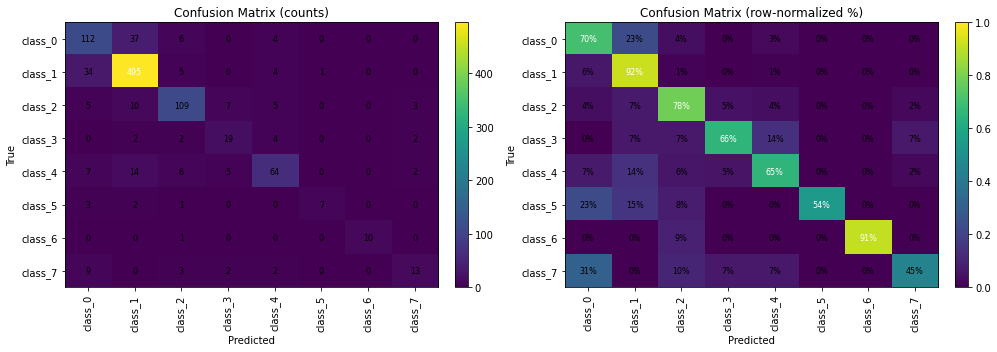

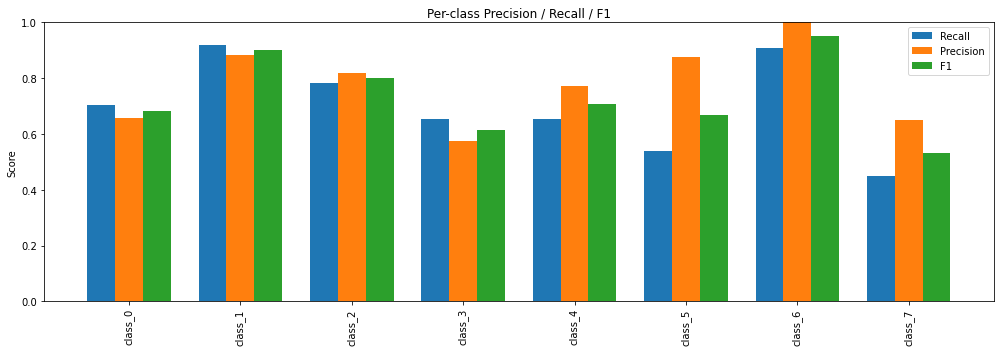

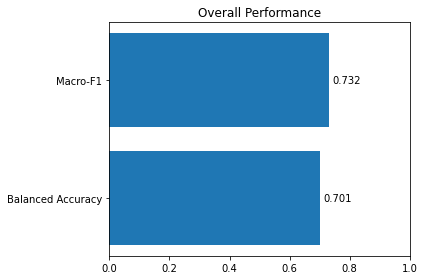

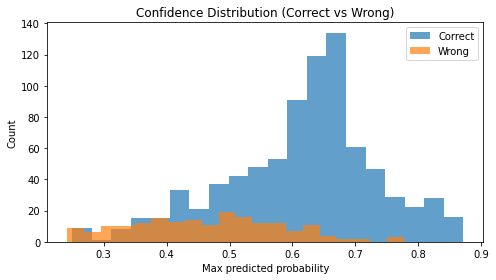

Plotting alpha-sweep (using overlapping IDs)…


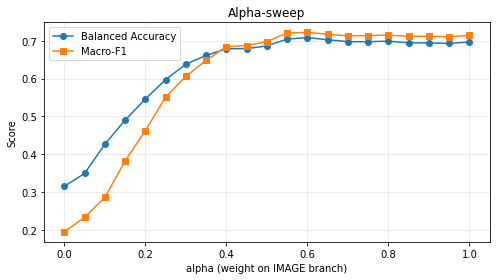

In [24]:
import os, json, numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, classification_report,
                             precision_recall_fscore_support,
                             balanced_accuracy_score, f1_score)

# ---------------- Load fused artifacts ----------------
P = np.load("oof_fused_probs.npy")          # [N, K]
y_true = np.load("oof_fused_labels.npy")    # [N]
y_pred = np.load("oof_fused_pred.npy")      # [N]

try:
    with open("fusion_artifacts.json") as f:
        art = json.load(f)
    label_cols = art.get("label_cols", None)
except Exception:
    label_cols = None

K = P.shape[1]
if not label_cols or len(label_cols) != K:
    label_cols = [f"class_{i}" for i in range(K)]

# ---------------- Metrics ----------------
bal_acc = balanced_accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average="macro")

prec, rec, f1, support = precision_recall_fscore_support(
    y_true, y_pred, labels=np.arange(K), zero_division=0
)

# ===================== 1) Confusion Matrix =====================
cm = confusion_matrix(y_true, y_pred, labels=np.arange(K))
cm_norm = cm / np.maximum(cm.sum(axis=1, keepdims=True), 1)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
im = ax[0].imshow(cm, aspect='auto')
ax[0].set_title("Confusion Matrix (counts)")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("True")
ax[0].set_xticks(np.arange(K)); ax[0].set_xticklabels(label_cols, rotation=90)
ax[0].set_yticks(np.arange(K)); ax[0].set_yticklabels(label_cols)
for i in range(K):
    for j in range(K):
        ax[0].text(j, i, cm[i, j], ha='center', va='center', fontsize=8, color='w' if cm[i,j] > cm.max()/2 else 'black')
fig.colorbar(im, ax=ax[0], fraction=0.046, pad=0.04)

im2 = ax[1].imshow(cm_norm, aspect='auto', vmin=0, vmax=1)
ax[1].set_title("Confusion Matrix (row-normalized %)")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("True")
ax[1].set_xticks(np.arange(K)); ax[1].set_xticklabels(label_cols, rotation=90)
ax[1].set_yticks(np.arange(K)); ax[1].set_yticklabels(label_cols)
for i in range(K):
    for j in range(K):
        ax[1].text(j, i, f"{cm_norm[i, j]*100:.0f}%", ha='center', va='center', fontsize=8,
                   color='w' if cm_norm[i,j] > 0.5 else 'black')
fig.colorbar(im2, ax=ax[1], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# ===================== 2) Per-class bars =====================
x = np.arange(K)
w = 0.25
fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(x - w, rec, width=w, label='Recall')
ax.bar(x,      prec, width=w, label='Precision')
ax.bar(x + w,  f1,   width=w, label='F1')
ax.set_xticks(x); ax.set_xticklabels(label_cols, rotation=90)
ax.set_ylim(0, 1); ax.set_ylabel("Score")
ax.set_title("Per-class Precision / Recall / F1")
ax.legend()
plt.tight_layout()
plt.show()

# ===================== 3) Summary bars (BA & Macro-F1) =====================
fig, ax = plt.subplots(figsize=(6, 4))
ax.barh(['Balanced Accuracy', 'Macro-F1'], [bal_acc, macro_f1])
for i, v in enumerate([bal_acc, macro_f1]):
    ax.text(v + 0.01, i, f"{v:.3f}", va='center')
ax.set_xlim(0, 1)
ax.set_title("Overall Performance")
plt.tight_layout()
plt.show()

# ===================== 4) Confidence histogram =====================
conf = P.max(axis=1)
correct = (y_pred == y_true)
fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(conf[correct], bins=20, alpha=0.7, label='Correct')
ax.hist(conf[~correct], bins=20, alpha=0.7, label='Wrong')
ax.set_xlabel("Max predicted probability")
ax.set_ylabel("Count")
ax.set_title("Confidence Distribution (Correct vs Wrong)")
ax.legend()
plt.tight_layout()
plt.show()

# ===================== 5) Optional: Alpha-sweep curve =====================
# If you still have original branches present:
if os.path.exists("oof_img_probs.npy") and os.path.exists("oof_meta_probs.npy") \
   and os.path.exists("oof_img_ids.npy") and os.path.exists("oof_meta_ids.npy") \
   and os.path.exists("oof_meta_labels.npy"):
    print("Plotting alpha-sweep (using overlapping IDs)…")
    P_img = np.load("oof_img_probs.npy")
    P_meta = np.load("oof_meta_probs.npy")
    ids_img = np.load("oof_img_ids.npy", allow_pickle=True).astype("U64")
    ids_meta = np.load("oof_meta_ids.npy", allow_pickle=True).astype("U64")
    y_meta_overlap = np.load("oof_meta_labels.npy")

    # Align by IDs
    id2row_meta = {iid: r for r, iid in enumerate(ids_meta)}
    keep_img, keep_meta = [], []
    for r_img, iid in enumerate(ids_img):
        if iid in id2row_meta:
            keep_img.append(r_img); keep_meta.append(id2row_meta[iid])
    keep_img = np.asarray(keep_img, dtype=int)
    keep_meta = np.asarray(keep_meta, dtype=int)
    if keep_img.size > 0:
        P_img_aln = P_img[keep_img]
        P_meta_aln = P_meta[keep_meta]
        y_overlap  = y_meta_overlap[keep_meta]
        # Make class dims match simply (skip advanced mapping for the plot)
        K_min = min(P_img_aln.shape[1], P_meta_aln.shape[1])
        P_img_aln = P_img_aln[:, :K_min]
        P_meta_aln = P_meta_aln[:, :K_min]

        alphas = np.linspace(0, 1, 21)
        ba_curve, f1_curve = [], []
        for a in alphas:
            Pf = a * P_img_aln + (1 - a) * P_meta_aln
            yhat = Pf.argmax(axis=1)
            ba_curve.append(balanced_accuracy_score(y_overlap, yhat))
            f1_curve.append(f1_score(y_overlap, yhat, average="macro"))

        fig, ax = plt.subplots(figsize=(7, 4))
        ax.plot(alphas, ba_curve, marker='o', label='Balanced Accuracy')
        ax.plot(alphas, f1_curve, marker='s', label='Macro-F1')
        ax.set_xlabel("alpha (weight on IMAGE branch)")
        ax.set_ylabel("Score")
        ax.set_title("Alpha-sweep")
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("No overlapping IDs available for alpha-sweep plot.")
else:
    print("Alpha-sweep skipped (branch OOF files not found).")
